# Credit Risk Model Recalibration in Python
This notebook demonstrates how to train a logistic regression model for PD estimation and recalibrate it using actual default outcomes.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
# Generate synthetic historical data
n_samples = 1000
historical_data = pd.DataFrame({
    'Income': np.random.normal(50000, 15000, n_samples),
    'Age': np.random.randint(20, 70, n_samples),
    'DebtToIncome': np.random.uniform(0.1, 0.5, n_samples),
    'CreditScore': np.random.normal(700, 50, n_samples),
    'Default': np.random.binomial(1, 0.1, n_samples)  # 10% default rate
})

# Prepare features
X = historical_data[['Income', 'Age', 'DebtToIncome', 'CreditScore']]
y = historical_data['Default']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression model
logit_model = LogisticRegression()
logit_model.fit(X_scaled, y)

# Store PD estimates
historical_data['PD_hat'] = logit_model.predict_proba(X_scaled)[:, 1]


In [4]:
# Generate synthetic current data
current_data = pd.DataFrame({
    'Income': np.random.normal(52000, 14000, n_samples),
    'Age': np.random.randint(22, 68, n_samples),
    'DebtToIncome': np.random.uniform(0.1, 0.6, n_samples),
    'CreditScore': np.random.normal(710, 55, n_samples),
    'Actual_Default': np.random.binomial(1, 0.12, n_samples)  # 12% default rate
})

# Standardize using the same scaler
X_current = current_data[['Income', 'Age', 'DebtToIncome', 'CreditScore']]
X_current_scaled = scaler.transform(X_current)

# Predict PDs using the original model
current_data['PD_hat'] = logit_model.predict_proba(X_current_scaled)[:, 1]


In [5]:
# Fit recalibration model: Actual default ~ PD_hat
X_recalibration = sm.add_constant(current_data[['PD_hat']])  # Add intercept
recalibration_model = sm.Logit(current_data['Actual_Default'], X_recalibration).fit()

# Predict recalibrated PDs
current_data['PD_recalibrated'] = recalibration_model.predict(X_recalibration)


Optimization terminated successfully.
         Current function value: 0.353210
         Iterations 6


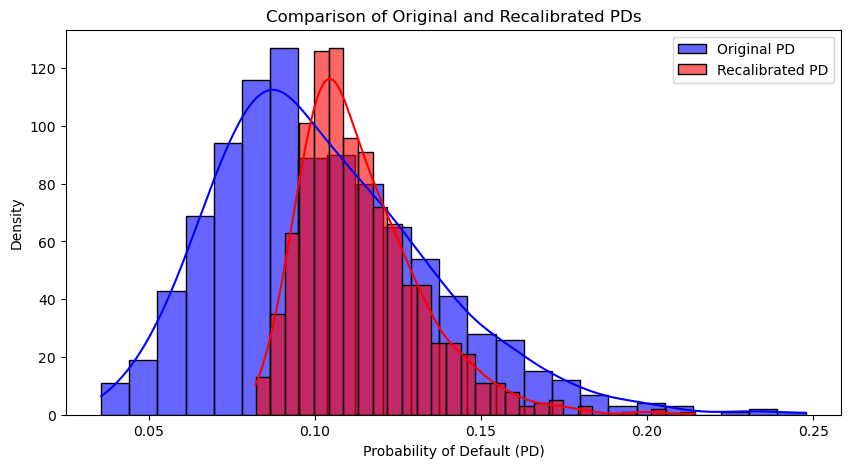

In [6]:
# Plot histograms of PD_hat vs PD_recalibrated
plt.figure(figsize=(10,5))
sns.histplot(current_data['PD_hat'], label='Original PD', kde=True, color='blue', alpha=0.6)
sns.histplot(current_data['PD_recalibrated'], label='Recalibrated PD', kde=True, color='red', alpha=0.6)
plt.xlabel('Probability of Default (PD)')
plt.ylabel('Density')
plt.legend()
plt.title('Comparison of Original and Recalibrated PDs')
plt.show()
